In [1]:
import tensorflow as tf
from model import Model
from input_pipe import InputPipe
from feeder import VarFeeder
from tqdm import trange
import matplotlib.pyplot as plt
import collections
import pandas as pd
import numpy as np
from trainer import predict
from hparams import build_hparams
import hparams
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/home/lihaocheng_i/.conda/envs/py3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/home/lihaocheng_i/.conda/envs/py3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def smape(true, pred):
    summ = np.abs(true) + np.abs(pred)
    smape = np.where(summ == 0, 0, np.abs(true - pred) / summ)
    #return np.mean(kaggle_smape) * 200
    return smape * 200

def mae(true, pred):
    return np.abs(np.abs(true) - np.abs(pred))

def mean_smape(true, pred):
    raw_smape = smape(true, pred)
    masked_smape = np.ma.array(raw_smape, mask=np.isnan(raw_smape))
    return masked_smape.mean()

def mean_mae(true, pred):
    raw_mae = mae(true, pred)
    masked_mae = np.ma.array(raw_mae, mask=np.isnan(raw_mae))
    return masked_mae.mean()

In [3]:
from make_features import read_all, find_start_end
df_all = read_all()
starts, ends = find_start_end(df_all.values)

/home/lihaocheng_i/.conda/envs/py3/lib/python3.6/site-packages/tables/leaf.py:414: PerformanceWarning: The Leaf ``/df/block0_values`` is exceeding the maximum recommended rowsize (104857600 bytes);
be ready to see PyTables asking for *lots* of memory and possibly slow
I/O.  You may want to reduce the rowsize by trimming the value of
dimensions that are orthogonal (and preferably close) to the *main*
dimension of this leave.  Alternatively, in case you have specified a
very small/large chunksize, you may want to increase/decrease it.
  PerformanceWarning)
/home/lihaocheng_i/.conda/envs/py3/lib/python3.6/site-packages/pandas/io/pytables.py:734: FutureWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help auto

In [4]:
prev = df_all.iloc[:, :-63]#.loc[:,:'2017-07-08']


In [5]:
paths = [p for p in tf.train.get_checkpoint_state('data/cpt/s32').all_model_checkpoint_paths]

In [6]:
paths

['data/cpt/s32/cpt-100', 'data/cpt/s32/cpt-127']

In [7]:
#tf.reset_default_graph()
#preds = predict(paths, default_hparams(), back_offset=0,
#                    n_models=3, target_model=0, seed=2, batch_size=2048, asgd=True)
t_preds = []
for tm in range(3):
    tf.reset_default_graph()
    t_preds.append(predict(paths, build_hparams(hparams.params_s32), back_offset=0, predict_window=63,
                    n_models=3, target_model=tm, seed=2, batch_size=1024, asgd=True))


INFO:tensorflow:Restoring parameters from data/vars/feeder.cpt
INFO:tensorflow:Restoring parameters from data/cpt/s32/cpt-100
0....🎉
INFO:tensorflow:Restoring parameters from data/cpt/s32/cpt-127
0....🎉
INFO:tensorflow:Restoring parameters from data/vars/feeder.cpt
INFO:tensorflow:Restoring parameters from data/cpt/s32/cpt-100
0....🎉
INFO:tensorflow:Restoring parameters from data/cpt/s32/cpt-127
0....🎉
INFO:tensorflow:Restoring parameters from data/vars/feeder.cpt
INFO:tensorflow:Restoring parameters from data/cpt/s32/cpt-100
0....🎉
INFO:tensorflow:Restoring parameters from data/cpt/s32/cpt-127
0....🎉


In [8]:
preds=sum(t_preds) /3

In [9]:
missing_vm = prev.index.difference(preds.index)
# Use zeros for missing pages
rmdf = pd.DataFrame(index=missing_vm,
                    data=np.tile(0, (len(preds.columns),len(missing_vm))).T, columns=preds.columns)
f_preds = preds.append(rmdf).sort_index()

# Use zero for negative predictions
f_preds[f_preds < 0.5] = 0
# Rouns predictions to nearest int
f_preds = np.round(f_preds).astype(np.int64)

Visual sanity check

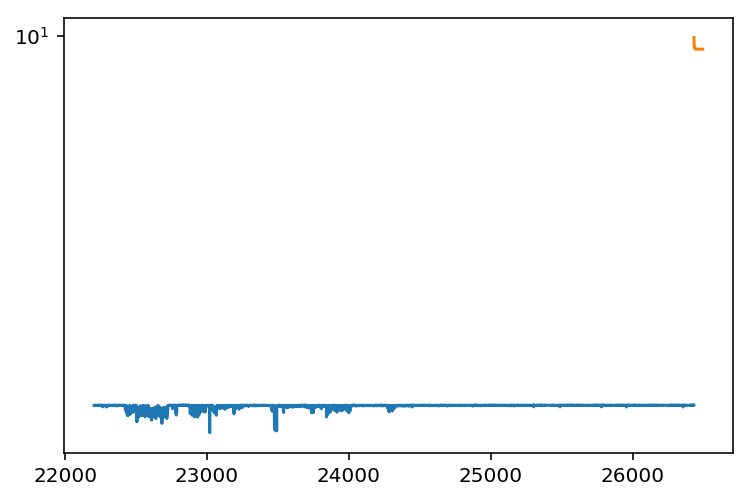

In [18]:
vm = 203
prev.loc[vm, starts[vm]+1000:ends[vm]].plot(logy=True)

#gt.loc[page].fillna(0).plot(logy=True)
(f_preds.loc[vm]/1000).plot(logy=True)

In [15]:
vm = 203
type(prev.loc[vm, starts[vm]:ends[vm]])

pandas.core.series.Series

In [23]:
prev.loc[0, starts[0]:ends[0]]

21034    8.000014
21035    9.019422
21036    7.520235
21037    6.413459
21038    6.469250
21039    6.723832
21040    7.928046
21041    6.841615
21042    6.308098
21043    6.405228
21044    7.116394
21045    7.121252
21046    6.924612
21047    7.334329
21048    9.207737
21049    8.443116
21050    8.793460
21051    9.208739
21052    7.178545
21053    7.680176
21054    8.708640
21055    7.210080
21056    6.300786
21057    6.383507
21058    6.876265
21059    6.261492
21060    6.356108
21061    6.236370
21062    6.234411
21063    6.224558
           ...   
26403    9.318298
26404    9.325453
26405    9.298260
26406    9.316501
26407    9.311542
26408    9.313348
26409    9.286560
26410    9.278653
26411    9.285170
26412    9.248021
26413    9.257510
26414    9.294682
26415    9.235521
26416    9.318926
26417    9.310819
26418    9.303740
26419    9.346880
26420    9.335474
26421    9.311813
26422    9.300821
26423    9.319284
26424    9.302828
26425    9.313979
26426    9.308283
26427    9

In [11]:
def read_keys():
    import os.path
    key_file = 'data/keys2.pkl'
    if os.path.exists(key_file):
        return pd.read_pickle(key_file)
    else:
        print('Reading keys...')
        raw_keys = pd.read_csv('data/key_2.csv.zip')
        print('Processing keys...')
        pagedate = raw_keys.Page.str.rsplit('_', expand=True, n=1).rename(columns={0:'page',1:'date_str'})
        keys = raw_keys.drop('Page', axis=1).assign(page=pagedate.page, date=pd.to_datetime(pagedate.date_str))
        del raw_keys, pagedate
        print('Pivoting keys...')
        pkeys = keys.pivot(index='page', columns='date', values='Id')
        print('Storing keys...')
        pkeys.to_pickle(key_file)
        return pkeys
keys = read_keys()    

In [12]:
subm_preds = f_preds.loc[:, '2017-09-13':]
assert np.all(subm_preds.index == keys.index)
assert np.all(subm_preds.columns == keys.columns)
answers = pd.DataFrame({'Id':keys.values.flatten(), 'Visits':np.round(subm_preds).astype(np.int64).values.flatten()})
answers.to_csv('data/submission.csv.gz', compression='gzip', index=False, header=True)


In [14]:
f_preds

,2017-09-12 00:00:00,2017-09-13 00:00:00,2017-09-14 00:00:00,2017-09-15 00:00:00,2017-09-16 00:00:00,2017-09-17 00:00:00,2017-09-18 00:00:00,2017-09-19 00:00:00,2017-09-20 00:00:00,2017-09-21 00:00:00,...,2017-11-04 00:00:00,2017-11-05 00:00:00,2017-11-06 00:00:00,2017-11-07 00:00:00,2017-11-08 00:00:00,2017-11-09 00:00:00,2017-11-10 00:00:00,2017-11-11 00:00:00,2017-11-12 00:00:00,2017-11-13 00:00:00
!vote_en.wikipedia.org_all-access_all-agents,11,11,10,10,10,9,10,10,10,9,...,7,6,6,7,7,7,6,7,6,6
!vote_en.wikipedia.org_all-access_spider,2,2,2,2,2,2,2,2,2,2,...,3,2,2,2,2,2,2,3,2,2
!vote_en.wikipedia.org_desktop_all-agents,6,5,5,5,5,4,5,5,5,5,...,4,3,4,4,4,4,4,4,3,4
"""Awaken,_My_Love!""_en.wikipedia.org_all-access_all-agents",1081,1089,1075,1056,1062,1092,1096,1112,1103,1093,...,1094,1120,1137,1149,1138,1128,1108,1106,1127,1146
"""Awaken,_My_Love!""_en.wikipedia.org_all-access_spider",21,21,20,19,20,20,20,20,20,19,...,19,18,19,18,18,18,18,19,18,18
"""Awaken,_My_Love!""_en.wikipedia.org_desktop_all-agents",641,645,633,603,571,595,637,652,648,638,...,585,605,644,655,651,644,622,592,609,648
"""European_Society_for_Clinical_Investigation""_en.wikipedia.org_all-access_all-agents",1,2,2,2,2,2,2,2,2,2,...,2,1,2,2,2,2,2,2,1,2
"""European_Society_for_Clinical_Investigation""_en.wikipedia.org_all-access_spider",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"""European_Society_for_Clinical_Investigation""_en.wikipedia.org_desktop_all-agents",1,1,2,2,2,2,2,2,2,2,...,2,1,2,2,1,1,1,2,1,2
"""Heroes""_(David_Bowie_album)_en.wikipedia.org_all-access_all-agents",613,611,607,598,595,611,625,618,622,614,...,622,632,631,627,628,603,602,605,627,632


In [15]:
prev.loc[missing_pages, '2016-12-15':]

,2016-12-15 00:00:00,2016-12-16 00:00:00,2016-12-17 00:00:00,2016-12-18 00:00:00,2016-12-19 00:00:00,2016-12-20 00:00:00,2016-12-21 00:00:00,2016-12-22 00:00:00,2016-12-23 00:00:00,2016-12-24 00:00:00,...,2017-09-02 00:00:00,2017-09-03 00:00:00,2017-09-04 00:00:00,2017-09-05 00:00:00,2017-09-06 00:00:00,2017-09-07 00:00:00,2017-09-08 00:00:00,2017-09-09 00:00:00,2017-09-10 00:00:00,2017-09-11 00:00:00
100_лучших_героев_комиксов_по_версии_IGN_ru.wikipedia.org_all-access_spider,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN
100_лучших_героев_комиксов_по_версии_IGN_ru.wikipedia.org_desktop_all-agents,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN
100_лучших_героев_комиксов_по_версии_IGN_ru.wikipedia.org_mobile-web_all-agents,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015年華潔洗滌罷工事件_zh.wikipedia.org_all-access_all-agents,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015年華潔洗滌罷工事件_zh.wikipedia.org_all-access_spider,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015年華潔洗滌罷工事件_zh.wikipedia.org_desktop_all-agents,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
????:Andrey_Belloly_1.jpg_ru.wikipedia.org_all-access_all-agents,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
????:Andrey_Belloly_1.jpg_ru.wikipedia.org_all-access_spider,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
????:Andrey_Belloly_1.jpg_ru.wikipedia.org_desktop_all-agents,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Akash_Thosar_en.wikipedia.org_mobile-web_all-agents,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
